# 导入必要的工具包

In [1]:
#sk里面的实现
from xgboost import XGBClassifier
#单独实现
import xgboost as xgb
#读取文件的类
import pandas as pd
#矩阵的类
import numpy as np
#交叉验证的类
from sklearn.model_selection import GridSearchCV
#分层采样的类
from sklearn.model_selection import StratifiedKFold
#评分标准 log似然损失
from sklearn.metrics import log_loss
#画图的类
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 读取数据

In [2]:
#读取csv文件
train = pd.read_csv("RentListingInquries_FE_train.csv")
#显示头5行信息
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [3]:
#查看详细信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 228 entries, bathrooms to interest_level
dtypes: float64(9), int64(219)
memory usage: 85.8 MB


In [4]:
#查看是否有空值
train.isnull()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


没有发现空值的情况

# 查看样本分布是否均匀

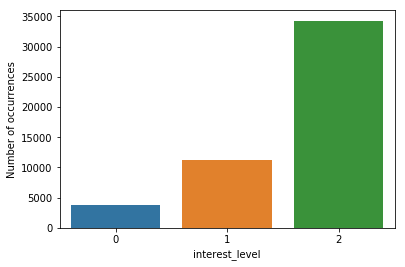

In [5]:
#拿出y轴的结果画图
sns.countplot(train.interest_level);
#设置x轴的名字
pyplot.xlabel('interest_level');
#设置y轴的名字
pyplot.ylabel('Number of occurrences');

不够均匀，非常感兴趣的占大多数

# 拿到训练集数据的X核y轴

In [6]:
#拿到y轴的值
y_train = train['interest_level']
#从训练集中删除y轴interest_level
train = train.drop(["interest_level"], axis=1)
#把训练集变为矩阵
X_train = np.array(train)


# 因为数据量不均匀  要按比例采样

In [7]:
#实例化分层采样的类
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
#n_splits=5 切割5次
#shuffle=True  是否进行落地计算
#random_state=3 随机的次数

第一轮参数调整得到的n_estimators最优值（299），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss

In [8]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5

#设置树的最大深度为3到10之间  步长为2
max_depth = range(3,10,2)
#叶子节点需要的最小样本权重  1到6之间  步长为2
min_child_weight = range(1,6,2)
#把参数变为map
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
#max_depth=max_depth设置树的最大深度
#min_child_weight=min_child_weight  叶子节点需要的最小样本权重

param_test2_1

{'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]}

In [9]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=699,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,cxd9
        objective= 'multi:softprob',
        seed=3)
#learning_rate =0.1  学习率
#n_estimators=699 弱分类器的数目
#max_depth=5  树的最大深度
#min_child_weight=1 叶子节点需要的最小权重
#gamma=0 节点分裂所需的最小损失函数下降值
#subsample=0.3 样本采样比例
#colsample_bytree=0.8  每棵树所用的特征比例
#colsample_bylevel=0.7 树在每层每个分裂的所用特征比例
#objective= 'multi:softprob'  待优化的目标参数  多分类问题
#seed=3  随机的种子数


#实例化交叉验证的类
gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
#xgb2_1  模型
#param_grid = param_test2_1  封装好的  树的最大深度和叶子节点需要的最小样本权重
#scoring='neg_log_loss'  得分标准  负log似然
#n_jobs=-1  开启所有的线程
#cv=kfold  交叉验证的类

#训练数据
gsearch2_1.fit(X_train , y_train)
#X_train   训练集x轴的值
#y_train   训练集y轴的值

#输出各个分数              输出最好的值                最好的分数
gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58967, std: 0.00360, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.59001, std: 0.00344, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.58984, std: 0.00335, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.59430, std: 0.00413, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.59398, std: 0.00483, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.59339, std: 0.00497, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.62953, std: 0.00748, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.61985, std: 0.00610, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.61495, std: 0.00603, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.68761, std: 0.00612, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.66533, std: 0.00592, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.64917, std: 0.00399, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_chil

In [10]:
#输出交叉验证的结果
gsearch2_1.cv_results_

/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/chenhafoen/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/chenhafoen/anac

{'mean_fit_time': array([ 725.47786131,  744.85222764,  747.3829916 ,  917.25999532,
         652.08855987,  563.73024406,  761.93793678,  766.45983639,
        1094.90195374, 1865.18765306, 1689.0928668 , 1009.51872263]),
 'mean_score_time': array([ 2.54203806,  2.43749018,  2.36476684,  3.68035703,  2.8600141 ,
         3.22309914,  6.61166301,  9.48649478, 10.72370601, 17.26069398,
        10.41232381,  5.25917859]),
 'mean_test_score': array([-0.58966637, -0.59000708, -0.58983998, -0.59430199, -0.59398388,
        -0.59338662, -0.6295278 , -0.61984681, -0.61495283, -0.68761088,
        -0.6653279 , -0.6491661 ]),
 'mean_train_score': array([-0.52978153, -0.53225896, -0.53394335, -0.39778168, -0.41336159,
        -0.4224088 , -0.21856275, -0.25690556, -0.28300739, -0.08992793,
        -0.13572813, -0.16938852]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    F

Best: -0.589666 using {'max_depth': 3, 'min_child_weight': 1}


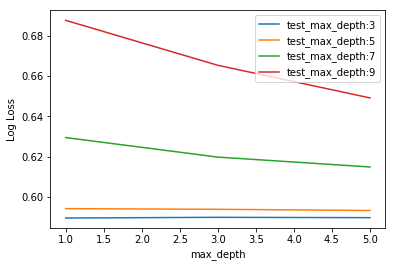

In [11]:
#输出最好的分数  和最好的参数
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
#拿到测试集的平均数
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
#拿到测试集的方差
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
#拿到训练集的平均数
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
#拿到训练集的方差
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]
#把结果变成df 再输出为csv违建
pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

#拿到测试集的分数
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
#len(max_depth)  多少个数组
#len(min_child_weight)  数组里有多少个元素

#拿到训练集的分数
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))
#len(max_depth)  多少个数组
#len(min_child_weight)  数组里有多少个元素


for i, value in enumerate(max_depth):
    #画出图
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
    #min_child_weight  x轴的值 叶子节点需要的最小样本权重
    #-test_scores[i]  y轴的值  评分
    #label= 'test_max_depth:'   + str(value)  标签名
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))

#画面自适应
pyplot.legend()
#设置x轴的值
pyplot.xlabel( 'max_depth' ) 
#设置y轴的值
pyplot.ylabel( 'Log Loss' )
#保存成图片
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )